<a href="https://colab.research.google.com/github/EduFdezSoy/safety-first/blob/master/simple_without_dropouts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Safety helmet detector

Source: https://www.kaggle.com/ehddnr301/helmet-classification

In [13]:
# Uncomment for install tensorflow 1.15.
!pip install tensorflow==1.15

In [14]:
# Imports
import cv2
import os
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time
from skimage import io, transform
from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Activation, BatchNormalization, MaxPooling2D, Dropout
# Check Tensorflow version.
tf.version.VERSION

'1.15.0'

## 1. Loading Data

In [15]:
# Uncomment for clonning the repository
!git clone https://github.com/sergiorodenas/ml-data.git

fatal: destination path 'ml-data' already exists and is not an empty directory.


In [16]:
# Image constants
IMAGE_WIDTH=100
IMAGE_HEIGHT=100
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
PATH1='./ml-data/helmet-dataset/Train_positive/Train_positive/'
PATH2='./ml-data/helmet-dataset/Train_negative/Train_negative/'

In [17]:
# Getting the images
filenames_list_yes = []
filenames_list_no = []

for filename in os.listdir(PATH1):
    filenames_list_yes.append(PATH1 + filename)
    
for filename in os.listdir(PATH2):
    filenames_list_no.append(PATH2 + filename)

df_yes = pd.DataFrame({
    'image': filenames_list_yes,
    'category': np.ones(len(filenames_list_yes), str)
})
df_no = pd.DataFrame({
    'image': filenames_list_no,
    'category': np.zeros(len(filenames_list_no), str)
})
print(df_yes.shape, df_no.shape)
df = df_yes.append(df_no, ignore_index=True)
print(df['image'][0])

(5160, 2) (6580, 2)
./ml-data/helmet-dataset/Train_positive/Train_positive/2338.jpg


## 2. Training data

In [18]:
# Hyperparameters
BATCH_SIZE=32
EPOCHS=100

In [19]:
#split data into train and valid set
train_df, valid_df = train_test_split(df, test_size = 0.15, stratify = df['category'], random_state = 3)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_valid = valid_df.shape[0]
print(train_df.shape)
print(valid_df.shape)

(9979, 2)
(1761, 2)


In [20]:
#We'll perform individually on train and validation set.
train_datagen = ImageDataGenerator(
                                   rescale=1./255,
                                   )

train_gen = train_datagen.flow_from_dataframe(train_df,
                                              x_col = 'image',
                                              y_col = 'category',
                                              target_size = IMAGE_SIZE,
                                              batch_size = BATCH_SIZE,
                                              class_mode='binary',
                                              validate_filenames=False
                                             )

#we do not augment validation data.
validation_datagen = ImageDataGenerator(rescale=1./255)
valid_gen = validation_datagen.flow_from_dataframe(
    valid_df, 
    x_col="image",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    validate_filenames=False
)

Found 9979 non-validated image filenames belonging to 2 classes.
Found 1761 non-validated image filenames belonging to 2 classes.


In [21]:
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu', strides=(2,2), input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', 'Precision'])


In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 49, 49, 64)        1792      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 47, 47, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 141376)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               36192512  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 36,231,489
Trainable params: 36,231,489
Non-trainable params: 0
_________________________________________________________________


## 3. Train the model

In [23]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
checkpointer = ModelCheckpoint(filepath = 'mask.weights.best.hdf5', save_best_only = True, save_weights_only = True)
early_stop = EarlyStopping(monitor='val_loss', patience=6)
callbacks = [learning_rate_reduction, checkpointer, early_stop]

In [24]:
start = time.time()

model.fit_generator(train_gen,
                    epochs = EPOCHS,
                    validation_data = valid_gen,
                    validation_steps=total_valid//BATCH_SIZE,
                    steps_per_epoch=total_train//BATCH_SIZE,
                    callbacks = callbacks)

endTime = time.time() - start
print("Total time: ", endTime, "seconds")

Epoch 1/100
311/311 [==============================] - 13s 41ms/step - loss: 0.1907 - acc: 0.9408 - precision_2: 0.9303 - val_loss: 0.0840 - val_acc: 0.9676 - val_precision_2: 0.9464
Epoch 2/100
311/311 [==============================] - 12s 39ms/step - loss: 0.0763 - acc: 0.9737 - precision_2: 0.9650 - val_loss: 0.0685 - val_acc: 0.9767 - val_precision_2: 0.9621
Epoch 3/100
311/311 [==============================] - 12s 39ms/step - loss: 0.0517 - acc: 0.9808 - precision_2: 0.9750 - val_loss: 0.0671 - val_acc: 0.9773 - val_precision_2: 0.9645
Epoch 4/100
311/311 [==============================] - 12s 38ms/step - loss: 0.0594 - acc: 0.9784 - precision_2: 0.9719 - val_loss: 0.0713 - val_acc: 0.9682 - val_precision_2: 0.9498
Epoch 5/100
311/311 [==============================] - 12s 38ms/step - loss: 0.0374 - acc: 0.9867 - precision_2: 0.9833 - val_loss: 0.0676 - val_acc: 0.9801 - val_precision_2: 0.9920
Epoch 6/100
311/311 [==============================] - 12s 39ms/step - loss: 0.0257 -

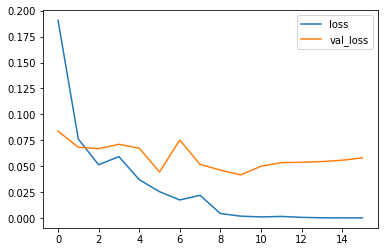

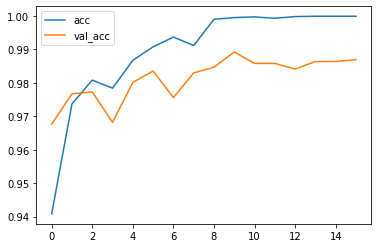

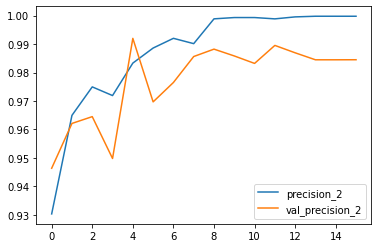

In [25]:
loss = pd.DataFrame(model.history.history)
loss[['loss', 'val_loss']].plot()
loss[['acc', 'val_acc']].plot()
loss[['precision_2', 'val_precision_2']].plot()

In [26]:
loss_mean = loss.mean()
loss_mean

loss               0.030871
acc                0.989557
precision_2        0.986966
val_loss           0.059099
val_acc            0.981321
val_precision_2    0.977113
lr                 0.000672
dtype: float64

In [27]:
print("Epochs: ", len(model.history.epoch))
print("Train time: ", endTime, "seconds") 

Epochs:  16
Train time:  194.35341596603394 seconds


In [28]:
print("|  Simple without Dropouts | {} | {} |  {} |   {} |  {} |      {} | {} |      {} |   {} |     |".format(loss_mean.acc, loss_mean.loss, loss_mean.val_acc, loss_mean.val_loss, loss_mean.precision_2, loss_mean.val_precision_2, loss_mean.lr, len(model.history.epoch), endTime))

|  Simple without Dropouts | 0.9895571656525135 | 0.030871352353305914 |  0.9813210181891918 |   0.059098931065035866 |  0.9869661182165146 |      0.977112639695406 | 0.0006718750319123501 |      16 |   194.35341596603394 |     |
